In [1]:
import GPy
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import pandas as pd
from scipy.stats import chisqprob
import pylab as pb

In [2]:
def build_XI(input_list):
    num_outputs = len(input_list)
    I = np.hstack( [np.repeat(j,_x.shape[0]) for _x,j in zip(input_list,range(num_outputs))] )
    X = np.vstack(input_list)
    X = np.hstack([X,I[:,None]])
    I = {'output_index':I[:,None]}
    return X,I

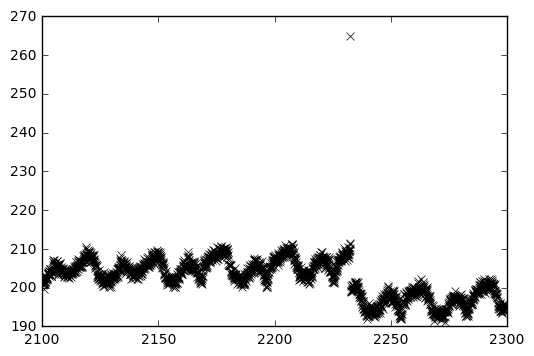

In [3]:
# mat_file1 = io.loadmat('2014_Dataset1.mat')
# t = mat_file1['t']
# p1 = mat_file1['p1']
# p2 = mat_file1['p2']
# x = np.arange(0,len(p2)/10,0.1)[:,None]
# plt.plot(x,p2,'kx')
# plt.show()
# for i in range(len(x)-1):
#     if p2[i]<190:
#         print (i)

mat_file1 = pd.read_csv('dataset 5211.csv')
p1 = np.array(mat_file1['P1'])[:,None]
p2 = np.array(mat_file1['P2'])[:,None]
x = np.arange(0,len(p2)/10,0.1)[:,None]
for i in range(len(p2)):
    if p2[i]<5:
        p2[i] = p2[i]*100
# plt.plot(x[0:101682],p2[0:101682],'kx')
# plt.plot(x[Mon[1]:Mon[2]],p2[Mon[1]:Mon[2]],'kx')
# plt.show()

plt.plot(x[21000:23000],p2[21000:23000],'kx')
plt.show()

In [4]:
import pickle
f = open('d:/hyperparameter1_4500','rb')
gp = pickle.load(f)
f.close()

In [5]:
def plot_2outputs(m,xlim,x_1,x_2):
    fig = pb.figure(figsize=(12,8))
    fig.add_subplot(111, frameon=False)
    plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
    plt.grid(False)
    
    plt.xlabel('X',fontsize=16)
    plt.ylabel('Y',fontsize=16)
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,len(x_1)),ax=ax1)
    ax1.legend(loc=3)

    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(len(x_1),len(x_1)+len(x_2)),ax=ax2)
    ax2.legend(loc=3)

In [6]:
Month = []
for i in range(len(mat_file1)):
    if mat_file1['Day'][i] == 1 and mat_file1['Hour'][i] == 0 and mat_file1['Minute'][i]==0:
        Month.append(i)
Mon = list(Month)[0:10]+[86897]+[92773]+[Month[11]]
mat_file1.loc[Mon,:]

,HISTID,Year,Month,Day,Hour,Minute,P1,P2
0,5211,2014,1,1,0,0,5.941,200.854
8928,5211,2014,2,1,0,0,5.972,201.404
16992,5211,2014,3,1,0,0,5.999,204.333
25914,5211,2014,4,1,0,0,6.067,197.742
34551,5211,2014,5,1,0,0,6.121,198.291
43472,5211,2014,6,1,0,0,6.155,201.404
52108,5211,2014,7,1,0,0,6.088,197.376
61036,5211,2014,8,1,0,0,6.067,195.362
69964,5211,2014,9,1,0,0,6.155,195.911
78343,5211,2014,10,1,0,0,6.042,193.348


In [7]:
from spot import bidSPOT
q = 0.02 				# risk parameter
d = 120  				# depth parameter
s = bidSPOT(q,d) 

X = p2
X = np.reshape(X,(1,len(X))).flatten()
n_init = 2000
init_data = X[:n_init] 	# initial batch
data = X[n_init:] 
s.fit(init_data,data) 	# data import
s.initialize() 	  		# initialization step
results = s.run()    	# run
s.plot(results)


Initial threshold : {'down': -4.3103333333332898, 'up': 3.429791666666631}
Number of peaks : {'down': 37, 'up': 37}
Grimshaw maximum log-likelihood estimation ... [done]
	          Parameters               Upper               Lower
	------------------------------------------------------------
	                   γ               -0.31               -0.45
	                   σ                0.39                0.51
	          likelihood                9.57                4.42
	    Extreme quantile                3.42               -4.30
	------------------------------------------------------------


100%|███████████████████████████████████████████████████████████████████████| 289709/289709 [00:03<00:00, 83435.28it/s]


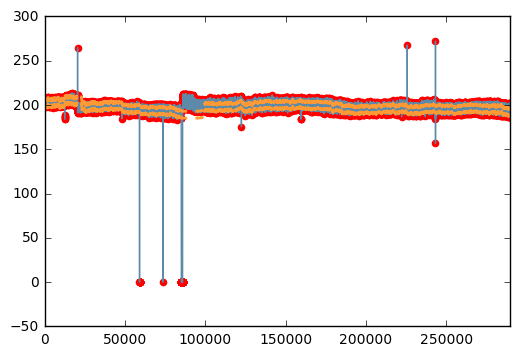

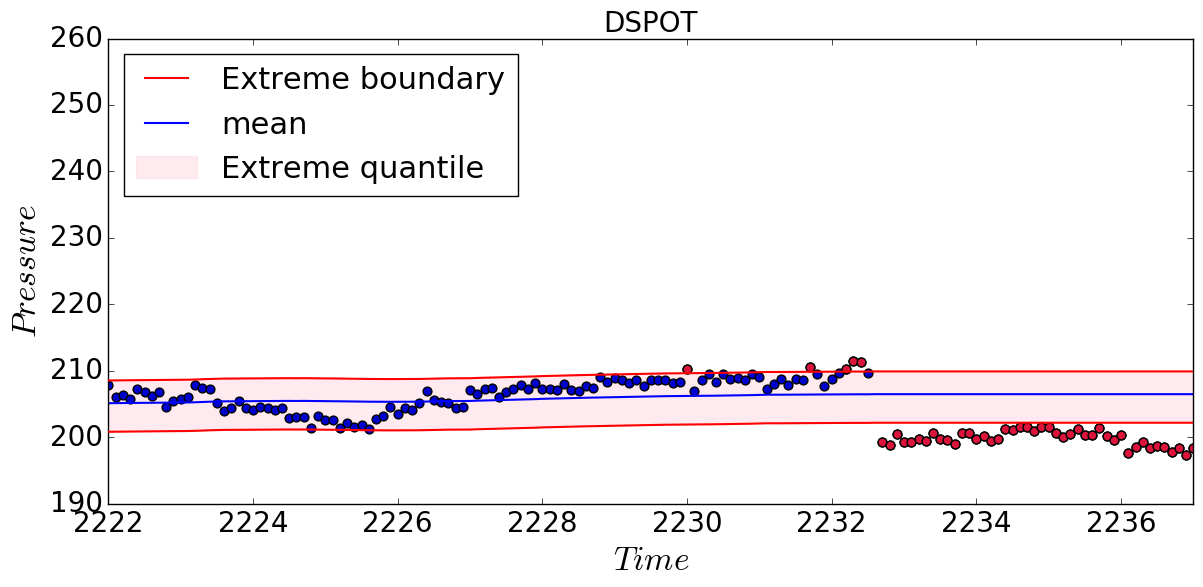

In [8]:
xs = (np.arange(s.data.size) + s.init_data.size)/10
l = 120

thup = results['upper_thresholds']
thdown = results['lower_thresholds']
ms = results['mean']
alarm = results['alarms']

fig = pb.figure(figsize=(14,6))
plt.title('DSPOT',fontsize = 20)
plt.xlim([(22100+l)/10,(22100+l)/10+15])
plt.ylim([190,260])
plt.tick_params(labelsize = 20)
plt.xlabel(r'$Time$',fontsize=24);plt.ylabel(r'$Pressure$',fontsize = 24)

plt.scatter(xs, s.data, s = 40,color='mediumblue', zorder=1,edgecolors='black')
plt.plot(xs,thup,color='red',label="Extreme boundary",lw=1.5,zorder=3)
plt.plot(xs,thdown,color='red',lw=1.5,zorder=3)
plt.plot(xs,ms,color='blue',label="mean",lw=1.5)
plt.fill_between(xs, thup, thdown, color='pink', alpha=0.3,label="Extreme quantile",zorder=0.5)
plt.scatter((np.array(alarm) + s.init_data.size)/10, s.data[alarm],s = 40,color='crimson',edgecolors='black',zorder=2)
plt.legend(fontsize=22, loc=2)

fig.savefig('case3.png',bbox_inches='tight')
plt.show()

# EVT-GP


In [9]:
def rbf(X,xt,m):
    Xt = xt*np.ones(len(X))[:,None]
    k = ((X-Xt)**2)/(2*(2*m.kern.ICM0.rbf.lengthscale[0])**2)
    ke = np.exp(-k)
    n = np.sum(ke)
    return n

def z_score(n):
    alpha = (2*np.log(n))**(-0.5)
    beta = (2*np.log(n))**(0.5) - (np.log(np.log(n))+np.log(2*np.pi))/(2*(2*np.log(n))**0.5)
    zp = beta-alpha*np.log(-np.log(0.98))
    return zp

def Mahalanobis_distance(model,x_test,y2):
    X,I = build_XI([x_test,x_test])
    mean, variance = model.predict(X, full_cov=True, Y_metadata=I)
    l = len(x_test)
    MD2 = np.dot(np.dot(np.transpose(y2-mean[l:2*l]),np.linalg.inv(variance[l:2*l,l:2*l])),y2-mean[l:2*l])

    return MD2

kern = gp.kern.copy()

In [10]:
s = 22100
l = 150

it = list(range(s,s+l))
kt = it.copy()
anomal_points = []
test_points = []
test_points2 = []
chi_sq = []
con_bd = []
step = 1

for i in range(200):
    # 기존 100개 model에 z 구하기
    new = it[len(it)-1]+step
    test_points.append(new)
    
    mul = GPy.models.GPCoregionalizedRegression([x[kt],x[it]],[p1[kt],p2[it]],kernel = kern)
    mul['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    print(new)
    # pointwise detection
   
    test_x = x[new]
    n = rbf(x[it],test_x,mul)
    zp = z_score(n)

    # 벗어나는 x찾기
    jt = it + list([new])
    X,I = build_XI([x[jt],x[jt]])
    mu,var = mul.predict(X,Y_metadata=I,kern=mul.kern,likelihood=mul.likelihood)
    mu2 = mu[int(len(mu)/2):len(mu)]
    var2 = var[int(len(mu)/2):len(mu)]
    
    con_ue = mu2 + np.sqrt(var2)*zp
    con_le = mu2 - np.sqrt(var2)*zp

    if i == 0:
        for j in range(len(con_ue)):
            con_bd.append([con_ue[j],con_le[j]])
            test_points2.append([jt[j],jt[j]])
    else:
        con_bd.append([con_ue[len(con_ue)-1],con_le[len(con_le)-1]])
        test_points2.append([new,new])
  
    if p2[new] > mu2[l] + zp*np.sqrt(var2[l]) or p2[new] < mu2[l] - zp*np.sqrt(var2[l]):
        anomal_points.append(new)
        it = it
        kt = kt + list([new])
        step += 1
    else:
        it.pop(0)
        it = it + list([new])
        kt.pop(0)
        kt = kt + list([new])
        step = 1
        
    # trajectory detection    
    
    mul2 = GPy.models.GPCoregionalizedRegression([x[kt],x[it[0:len(it)-12]]],[p1[kt],p2[it[0:len(it)-12]]],kernel = kern)
    mul2['.*Gaussian_noise_0.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_0.variance)
    mul2['.*Gaussian_noise_1.variance'].constrain_fixed(gp.mixed_noise.Gaussian_noise_1.variance)
    
    ct = it[len(it)-12:len(it)]
    md2 = Mahalanobis_distance(mul2,x[ct],p2[ct])
    cs = chisqprob(md2,len(ct))[0][0]
    chi_sq.append(cs)


22250
22251
22252
22253
22254
22255
22256
22257
22258
22259
22260
22261
22262
22263
22264
22265
22266
22267
22268
22269
22270
22271
22272
22273
22274
22275
22276
22277
22278
22279
22280
22281
22282
22283
22284
22285
22286
22287
22288
22289
22290
22291
22292
22293
22294
22295
22296
22297
22298
22299
22300
22301
22302
22303
22304
22305
22306
22307
22308
22309
22310
22311
22312
22313
22314
22315
22316
22317
22318
22319
22320
22321
22322
22323
22324
22325
22326
22327
22328
22329
22330
22331
22332
22333
22334
22335
22336
22337
22338
22339
22340
22341
22342
22343
22344
22345
22346
22347
22348
22349
22350
22351
22352
22353
22354
22355
22356
22357
22358
22359
22360
22361
22362
22363
22364
22365
22366
22367
22368
22369
22370
22371
22372
22373
22374
22375
22376
22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
2241

In [11]:
trend = []

for i in range(len(chi_sq)):
    if chi_sq[i] < 0.02:
        trend.append(test_points[i])
        print(test_points[i])
    
day = []
t_count = 0
for i in range(len(trend)-1):
    if i == 0:
        t_count += 1
    else:
        if trend[i]-trend[i-1]<6:
            pass
        else:
            if trend[i+1]-trend[i] <6:
                print(trend[i])
                t_count += 1

print(len(anomal_points),t_count)

22334
22335
22336
22337
22338
22339
22340
22341
22342
22343
22344
22345
22346
22347
22348
22349
8 1


In [12]:
f = (np.array(test_points2)[:,0]/10)[:,None][:,0]
c1 = (np.array(con_bd)[:,0])[:,0]
c2 = (np.array(con_bd)[:,1])[:,0]

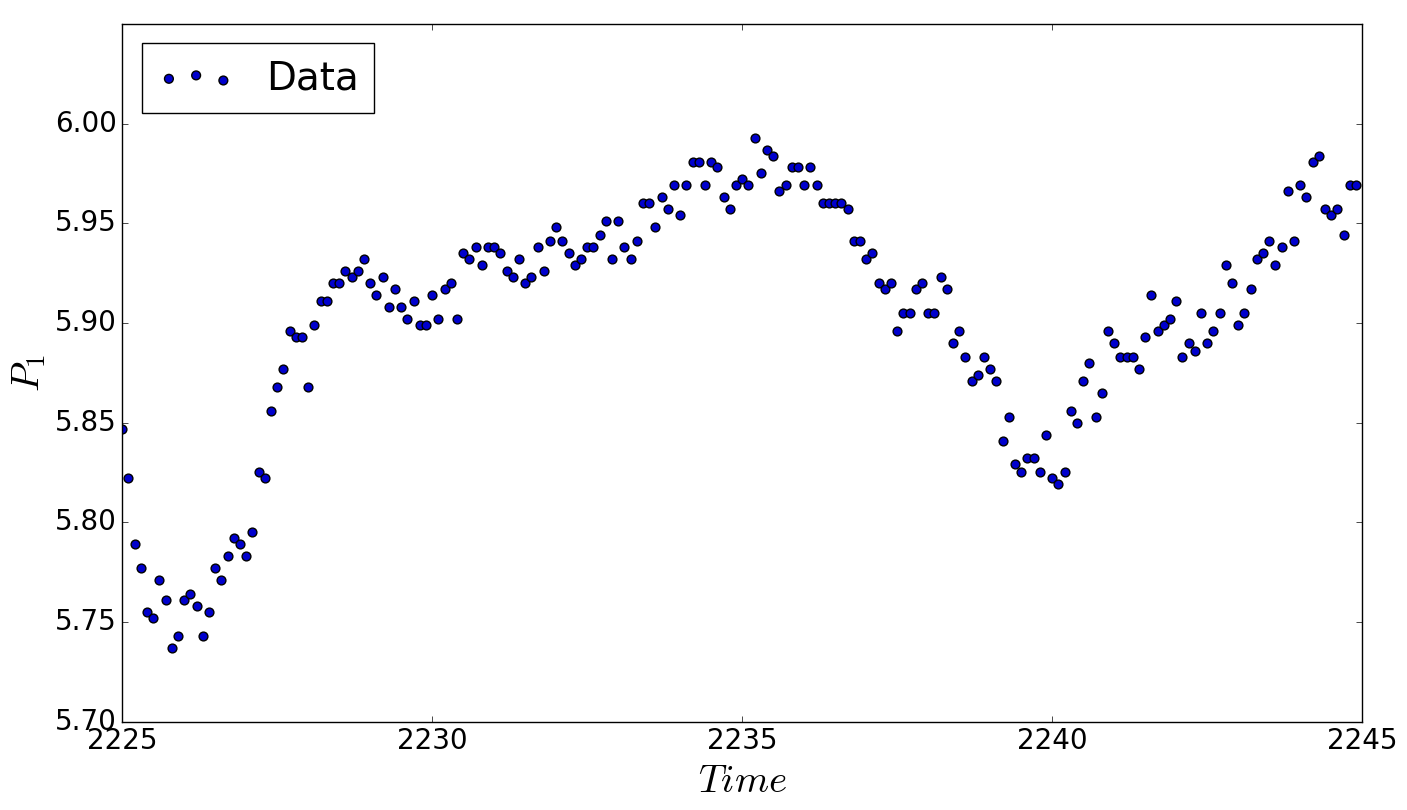

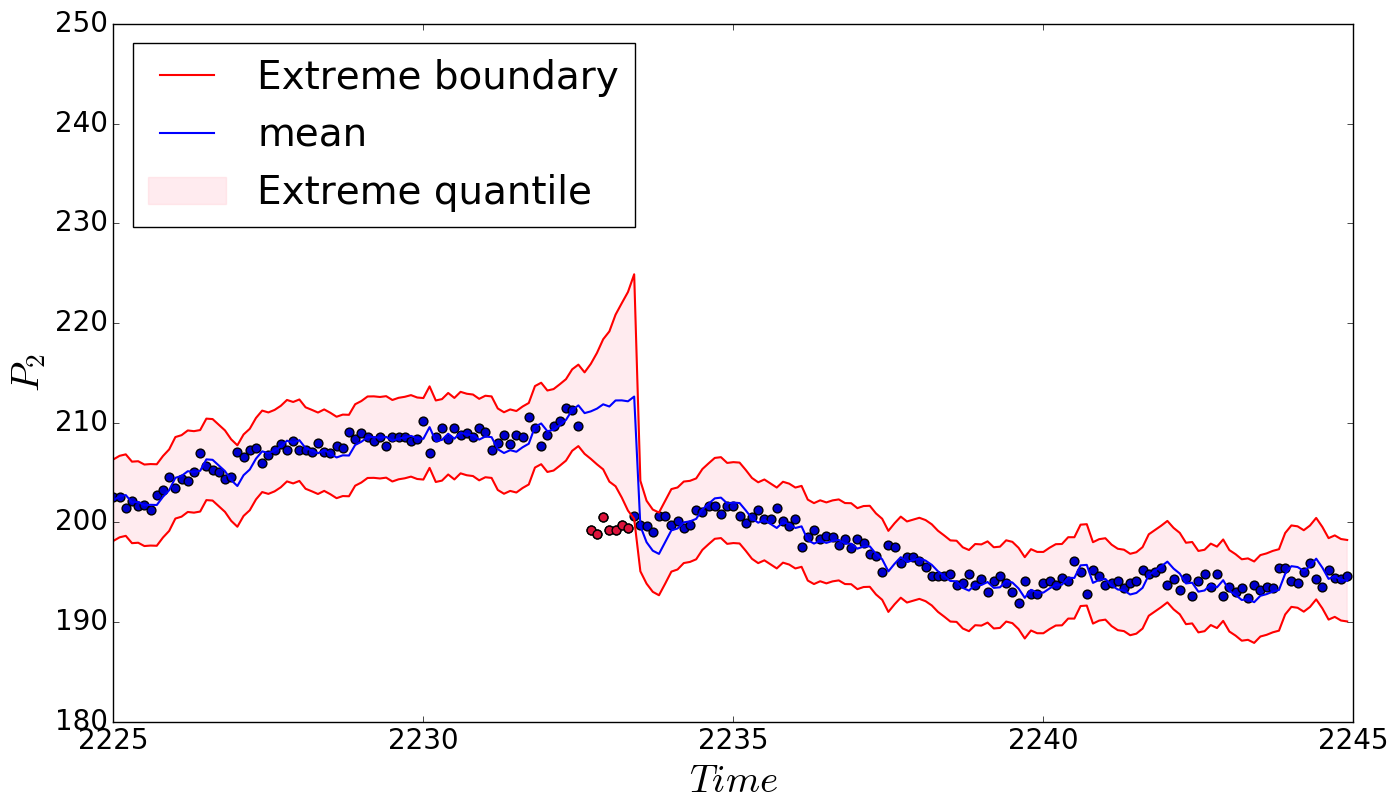

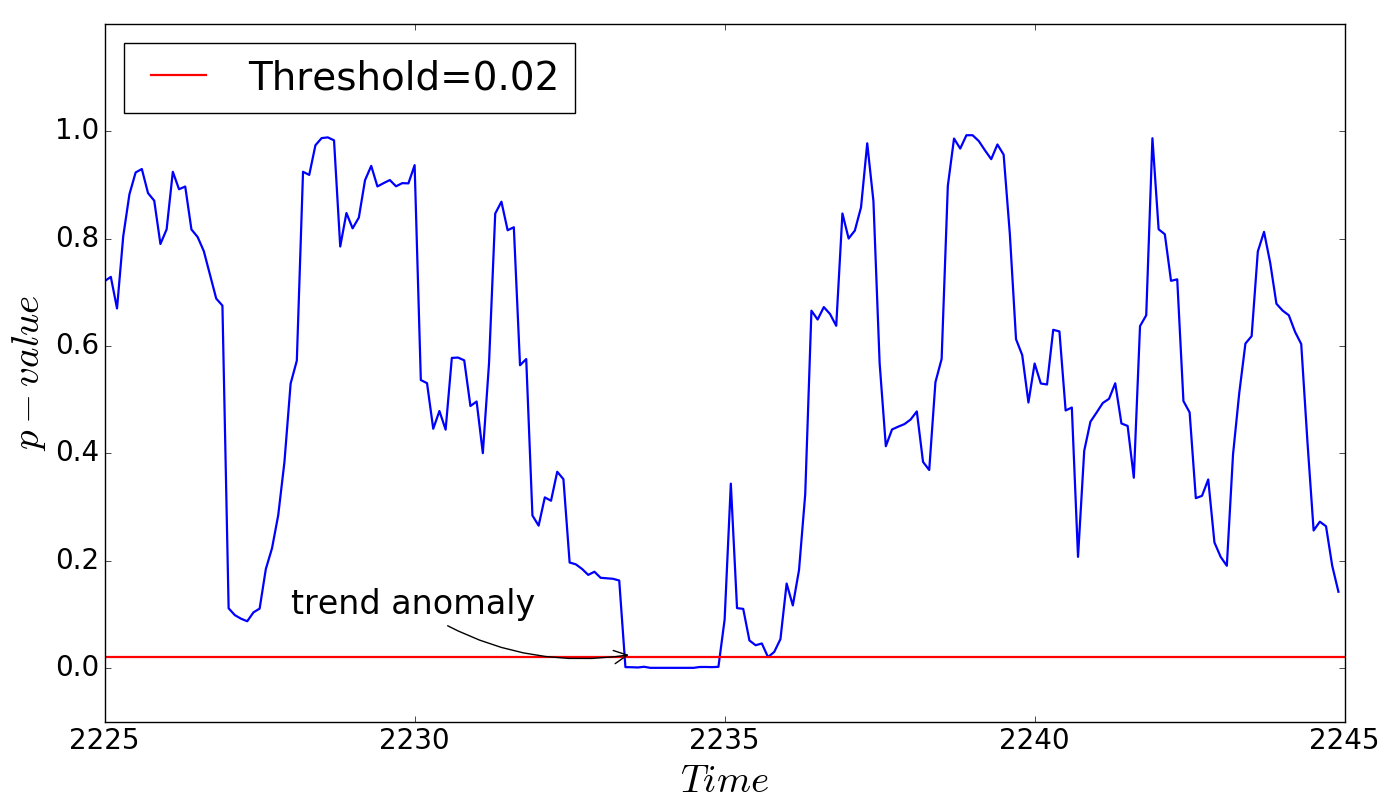

In [13]:
fig = pb.figure(figsize=(16,9))
plt.xlim([(s+l)/10,(s+l)/10+20])
plt.tick_params(labelsize=20)
plt.xlabel(r'$Time$',fontsize=28)
plt.ylabel(r'$P_{1}$',fontsize = 28)
plt.scatter(x[test_points],p1[test_points],s = 40,color='mediumblue', zorder=2,edgecolors='black', label = 'Data')
plt.legend(fontsize=28, loc=2)
fig.savefig('11_a.png',bbox_inches='tight')

fig2 = pb.figure(figsize=(16,9))
plt.xlim([(s+l)/10,(s+l)/10+20])
plt.ylim([180,250])
plt.tick_params(labelsize=20)
plt.xlabel(r'$Time$',fontsize=28)
plt.ylabel(r'$P_{2}$',fontsize = 28)
# ax1.plot(x[test_points],p2[test_points],'kx',mew = 1.5,label="Data")
plt.scatter(x[test_points],p2[test_points],s = 40,color='mediumblue', zorder=2,edgecolors='black')
plt.scatter(x[anomal_points],p2[anomal_points],s = 40,color='crimson', zorder=2,edgecolors='black')
plt.plot(np.array(test_points2)[:,0]/10,np.array(con_bd)[:,0],color='red',label="Extreme boundary",lw=1.5)
plt.plot(np.array(test_points2)[:,1]/10,np.array(con_bd)[:,1],color='red',lw=1.5)
plt.fill_between(f, c1, c2, color='pink', alpha=0.3,label="Extreme quantile")
plt.plot(np.array(test_points2)[:,1]/10,(c1+c2)/2,color='blue',label="mean",lw=1.5)
# ax1.legend(fontsize=22, loc='center left', bbox_to_anchor=(0.75, 0.75))
plt.legend(fontsize=28, loc=2)
fig2.savefig('11_b.png',bbox_inches='tight')

fig3 = pb.figure(figsize=(16,9))
plt.xlim([(s+l)/10,(s+l)/10+20])
plt.ylim([-0.1,1.2])
plt.tick_params(labelsize=20)
plt.xlabel(r'$Time$',fontsize=28)
plt.ylabel(r'$p-value$',fontsize = 28)
plt.plot(x[test_points],chi_sq,lw=1.6)
a = np.linspace((s+l)/10,(s+l)/10+50,100)
th = 0.02*np.ones(a.shape)
plt.plot(a,th,color='red',label="Threshold=0.02",lw=1.6)
# ax2.legend(fontsize=22, loc='center left', bbox_to_anchor=(0.75, 0.85))
plt.legend(fontsize=28, loc=2)
plt.annotate('trend anomaly', xy=(2233.5, 0.025), xytext=(2228, 0.1), fontsize = 24, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
fig3.savefig('11_c.png',bbox_inches='tight')

plt.show()

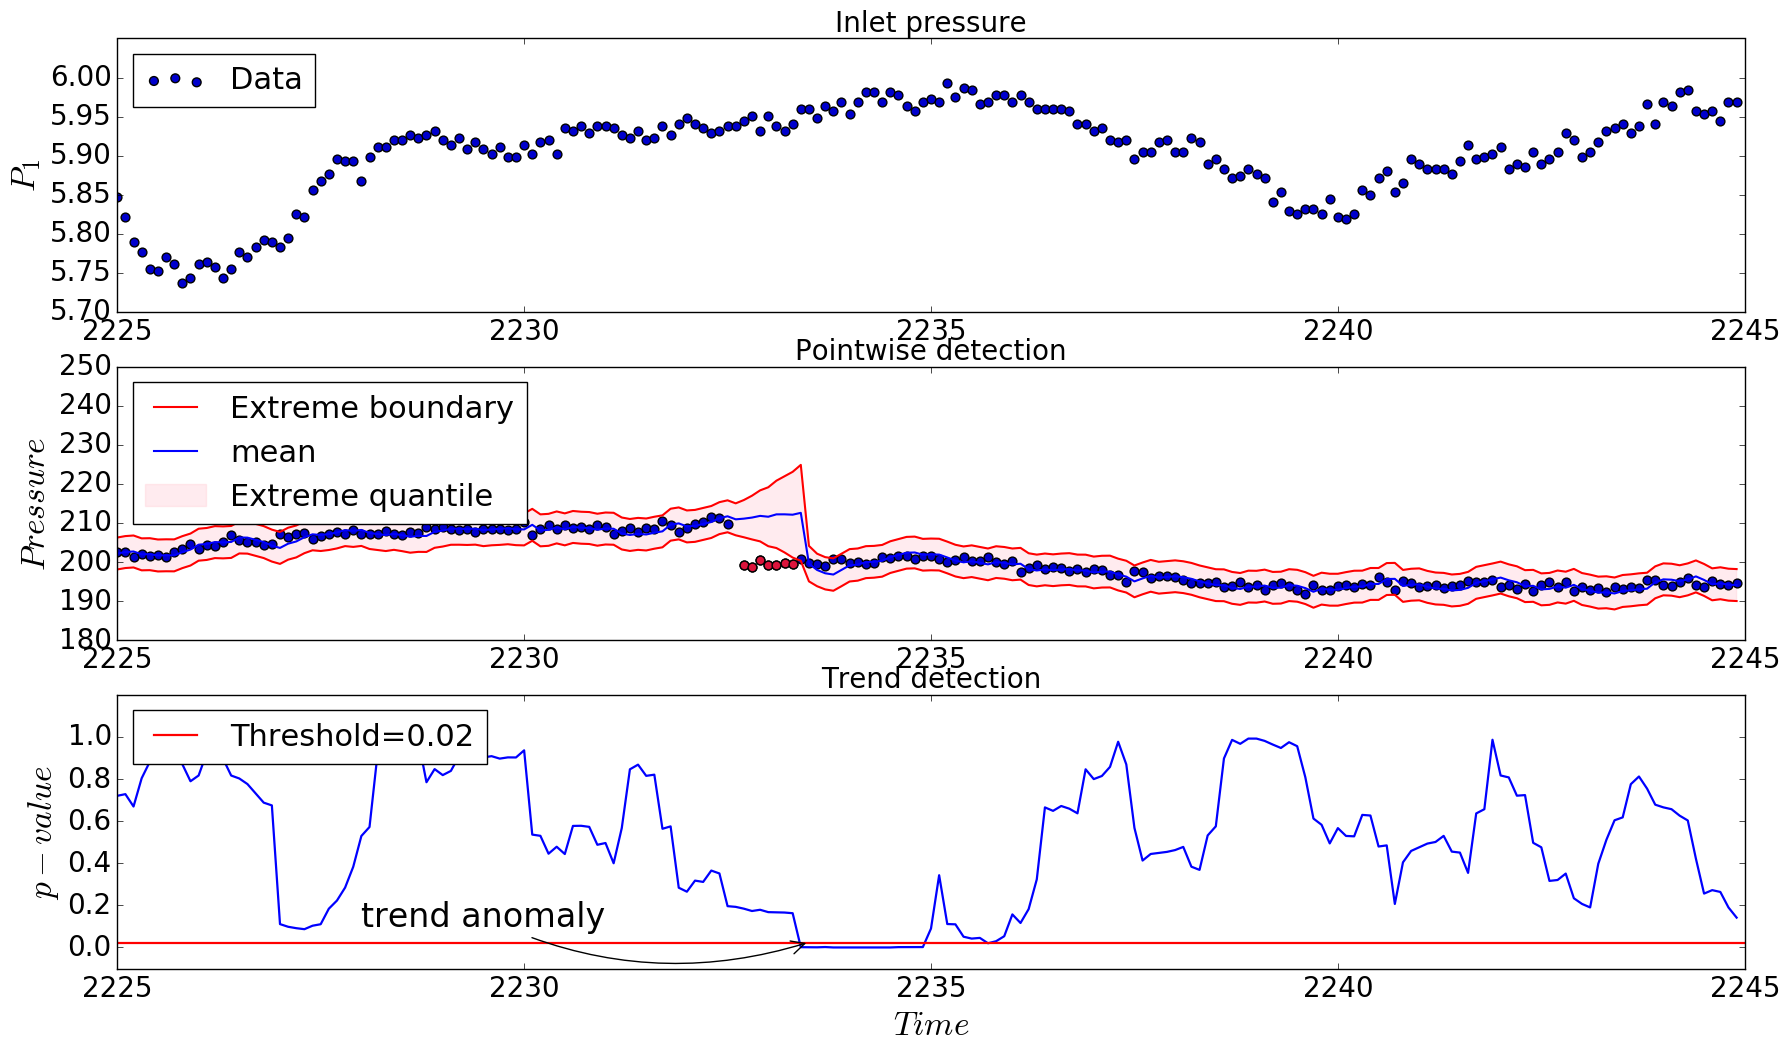

In [14]:
fig = pb.figure(figsize=(21,12))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)
    
# plt.xlabel('Time',fontsize=18)
# plt.ylabel('Pressure',fontsize=18)
#Output 1
ax = fig.add_subplot(311)
ax.set_xlim([(s+l)/10,(s+l)/10+20])
# ax.set_ylim([180,245])
ax.set_title('Inlet pressure',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_ylabel(r'$P_{1}$',fontsize = 24)
ax.scatter(x[test_points],p1[test_points],s = 40,color='mediumblue', zorder=2,edgecolors='black', label = 'Data')
# ax1.legend(fontsize=22, loc='center left', bbox_to_anchor=(0.75, 0.75))
ax.legend(fontsize=22, loc=2)


ax1 = fig.add_subplot(312)
ax1.set_xlim([(s+l)/10,(s+l)/10+20])
ax1.set_ylim([180,250])
ax1.set_title('Pointwise detection',fontsize=20)
ax1.tick_params(labelsize=20)
ax1.set_ylabel(r'$Pressure$',fontsize = 24)
ax1.scatter(x[test_points],p2[test_points],s = 40,color='mediumblue', zorder=2,edgecolors='black')
ax1.scatter(x[anomal_points],p2[anomal_points],s = 40,color='crimson', zorder=2,edgecolors='black')
ax1.plot(np.array(test_points2)[:,0]/10,np.array(con_bd)[:,0],color='red',label="Extreme boundary",lw=1.5)
ax1.plot(np.array(test_points2)[:,1]/10,np.array(con_bd)[:,1],color='red',lw=1.5)
ax1.fill_between(f, c1, c2, color='pink', alpha=0.3,label="Extreme quantile")
ax1.plot(np.array(test_points2)[:,1]/10,(c1+c2)/2,color='blue',label="mean",lw=1.5)
ax1.legend(fontsize=22, loc=2)
# ax1.annotate('anomal points', xy=(911.9, 186), xytext=(910.3, 185), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

#Output 2
ax2 = fig.add_subplot(313)
ax2.set_xlim([(s+l)/10,(s+l)/10+20])
ax2.set_ylim([-0.1,1.2])
ax2.set_title('Trend detection',fontsize=20)
ax2.tick_params(labelsize=20)
ax2.set_xlabel(r'$Time$',fontsize=24)
ax2.set_ylabel(r'$p-value$',fontsize = 24)
ax2.plot(x[test_points],chi_sq,lw=1.6)
a = np.linspace((s+l)/10,(s+l)/10+50,100)
th = 0.02*np.ones(a.shape)
ax2.plot(a,th,color='red',label="Threshold=0.02",lw=1.6)
ax2.legend(fontsize=22, loc=2)
ax2.annotate('trend anomaly', xy=(2233.5, 0.025), xytext=(2228, 0.1), fontsize = 24, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
# ax2.annotate('trend anomaly', xy=(911.1, 0.03), xytext=(912, 0.1), fontsize = 15, arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
fig.savefig('11.png',bbox_inches='tight')
plt.show()